In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


Columns Description:

Location: Street address of the crime incident.

Cross_Street: Cross street of the rounded address.

Latitude: Latitude coordinates of the crime incident.

Longitude: Longitude coordinates of the crime incident.

Date_Reported: Date the incident was reported.

Date_Occurred: Date the incident occurred.

Time_Occurred: Time the incident occurred in 24-hour military time.

Area_ID: LAPD's Geographic Area number.

Area_Name: Name designation of the LAPD Geographic Area.

Reporting_District_no: Reporting district number.

Part 1-2: Crime classification.

Modus_Operandi: Activities associated with the suspect.

Victim_Age: Age of the victim.

Victim_Sex: Gender of the victim.

Victim_Descent: Descent code of the victim.

Premise_Code: Premise code indicating the location of the crime.

Premise_Description: Description of the premise code.

Weapon_Used_Code: Weapon code indicating the type of weapon used.

Weapon_Description: Description of the weapon code.

Status: Status of the case.

Status_Description: Description of the status code.

Crime_Category: The category of the crime (Target Variable)

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

## Loading dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
test_df = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")

In [4]:
train_df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


## EDA

In [5]:
train_df.shape,test_df.shape

((20000, 22), (5000, 21))

In [6]:
train_df.columns

Index(['Location', 'Cross_Street', 'Latitude', 'Longitude', 'Date_Reported',
       'Date_Occurred', 'Time_Occurred', 'Area_ID', 'Area_Name',
       'Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Weapon_Used_Code', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')

In [7]:
train_df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [9]:
## Checking for columns containing null values
train_df.isnull().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

#### ** Columns having null values are: Cross_Street,Modus_Operandi, Victim_Sex, Victim_Descent, Weapon_Used_Code and Weapon_Description

In [10]:
## Exploring each column one by one

In [11]:
## Examine Location column

train_df['Location'].value_counts()

## It has simple text, we will drop it later

Location
6TH                                        33
7TH                                        32
VERMONT                      AV            31
6TH                          ST            31
7TH                          ST            30
                                           ..
2700 E  1ST                          ST     1
9300    SWINTON                      AV     1
MCKINLEY                                    1
WADE                         ST             1
DALTON                       AV             1
Name: count, Length: 12399, dtype: int64

In [12]:
## Cross_Street column
## encoding cross_street, replace null with 0 and not-null with 1

train_df['Cross_Street'] = train_df['Cross_Street'].apply(lambda x: 0 if pd.isnull(x) else 1)
test_df['Cross_Street'] = test_df['Cross_Street'].apply(lambda x: 0 if pd.isnull(x) else 1) 

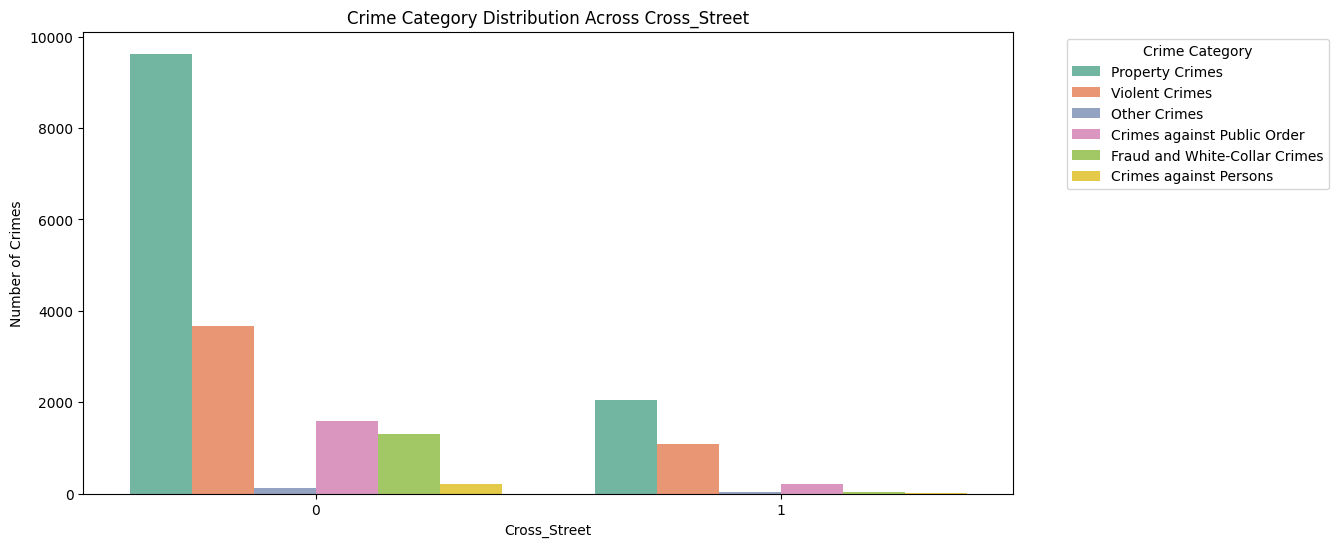

In [13]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Cross_Street', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Cross_Street')
plt.xlabel('Cross_Street')
plt.ylabel('Number of Crimes')

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **There are less crimes on location having cross street

In [14]:
train_df.isnull().sum()

Location                     0
Cross_Street                 0
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

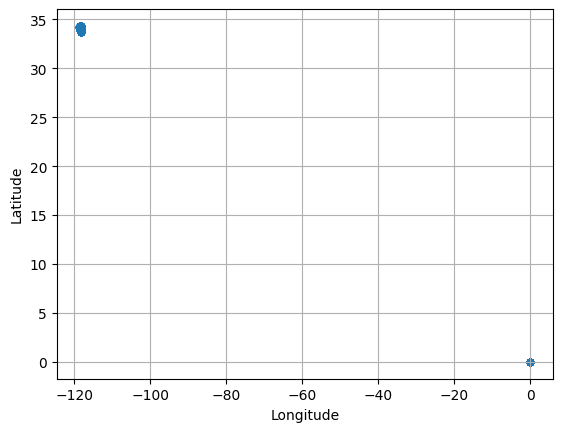

In [15]:
## Latitude and longitude column

train_df.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [16]:
## Removing outlier by replacing it with null and later impute the missing value with mean

train_df['Latitude'] = train_df['Latitude'].apply(lambda x: np.nan if x == 0 else x)
test_df['Latitude'] = test_df['Latitude'].apply(lambda x: np.nan if x == 0 else x)

train_df['Longitude'] = train_df['Longitude'].apply(lambda x: np.nan if x == 0 else x)
test_df['Longitude'] = test_df['Longitude'].apply(lambda x: np.nan if x == 0 else x)

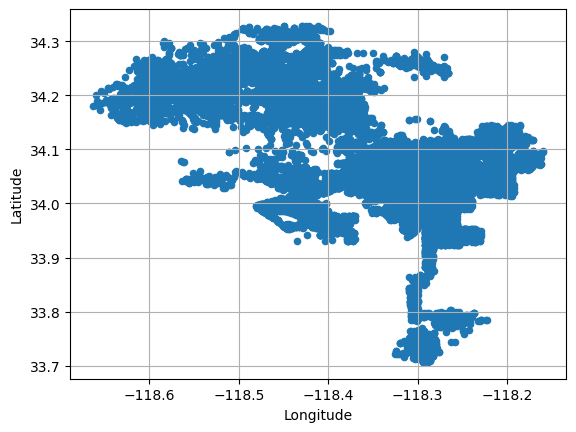

In [17]:
train_df.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()
## **There is high number of cases in the upper part of region 

In [18]:
train_df.isnull().sum()

Location                     0
Cross_Street                 0
Latitude                    78
Longitude                   78
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [19]:
## date_reported and date_occurred column has the object datatype
train_df['Date_Reported'].head()

0    03/09/2020 12:00:00 AM
1    02/27/2020 12:00:00 AM
2    08/21/2020 12:00:00 AM
3    11/08/2020 12:00:00 AM
4    02/25/2020 12:00:00 AM
Name: Date_Reported, dtype: object

In [20]:
# Convert date_reported to datetime format and extract only the date part

train_df['Date_Reported'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.date

test_df['Date_Reported'] = pd.to_datetime(test_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.date

In [21]:
# Convert date_occurred to datetime format and extract only the date part

train_df['Date_Occurred'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.date

test_df['Date_Occurred'] = pd.to_datetime(test_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.date

In [22]:
train_df['Date_Reported'].head()

0    2020-03-09
1    2020-02-27
2    2020-08-21
3    2020-11-08
4    2020-02-25
Name: Date_Reported, dtype: object

In [23]:
## We can extract new information from date_reported and date_occurred columns like day,month and year 

# Extract day, month, and year from Date_Reported in train set
train_df['Reported_Day'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.day.astype('int64')
train_df['Reported_Month'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.month.astype('int64')
train_df['Reported_Year'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.year.astype('int64')

# Extract day, month, and year from Date_Occurred in train set
train_df['Occurred_Day'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.day.astype('int64')
train_df['Occurred_Month'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.month.astype('int64')
train_df['Occurred_Year'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.year.astype('int64')

In [24]:
train_df['Reported_Day'].head()

0     9
1    27
2    21
3     8
4    25
Name: Reported_Day, dtype: int64

In [25]:
## Extract day,month and year for test set

# Extract day, month, and year from Date_Reported in test set
test_df['Reported_Day'] =pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.day.astype('int64')
test_df['Reported_Month'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.month.astype('int64')
test_df['Reported_Year'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p').dt.year.astype('int64')

# Extract day, month, and year from Date_Occurred in test set
test_df['Occurred_Day'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.day.astype('int64')
test_df['Occurred_Month'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.month.astype('int64')
test_df['Occurred_Year'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.year.astype('int64')  

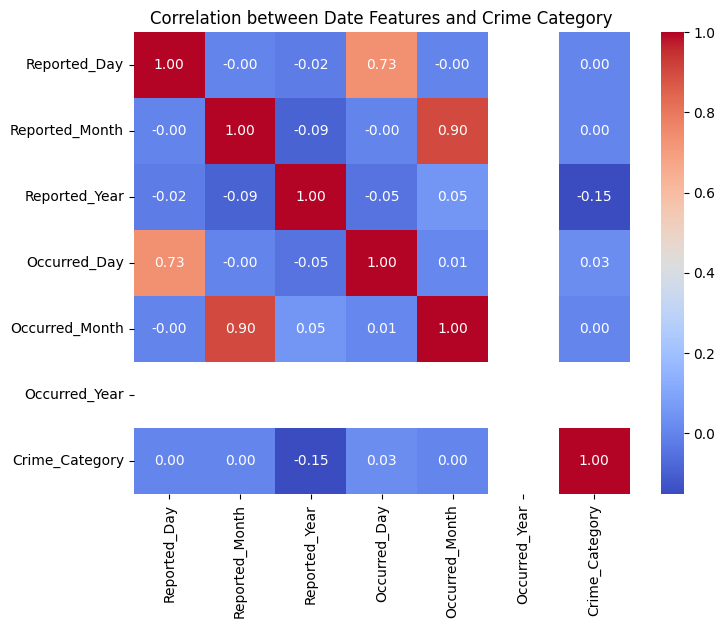

In [26]:
## Lets visualize the relation between Dtae occurred and date reported with crime category
columns = ['Reported_Day', 'Reported_Month', 'Reported_Year', 'Occurred_Day', 'Occurred_Month', 'Occurred_Year']

# Convert Crime_Category to numerical values if needed
crime_category_encoded = train_df['Crime_Category'].astype('category').cat.codes

# Combine it with the date-related columns
df_corr = train_df[columns].copy()
df_corr['Crime_Category'] = crime_category_encoded

# Compute the correlation matrix
corr = df_corr.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Date Features and Crime Category')
plt.show()

## **As we can see there is high correlation between occurred day/month and reported day/month

In [27]:
## We can extract new feature from above information
## Extract new feature: days lapsed to check if there is any relation between the difference of crime reported and crime occurred date with crime category

# Create the days_Lapsed column
train_df['Days_Lapsed'] = (pd.to_datetime(train_df['Date_Reported']) - pd.to_datetime(train_df['Date_Occurred'])).dt.days
test_df['Days_Lapsed'] = (pd.to_datetime(test_df['Date_Reported']) - pd.to_datetime(test_df['Date_Occurred'])).dt.days

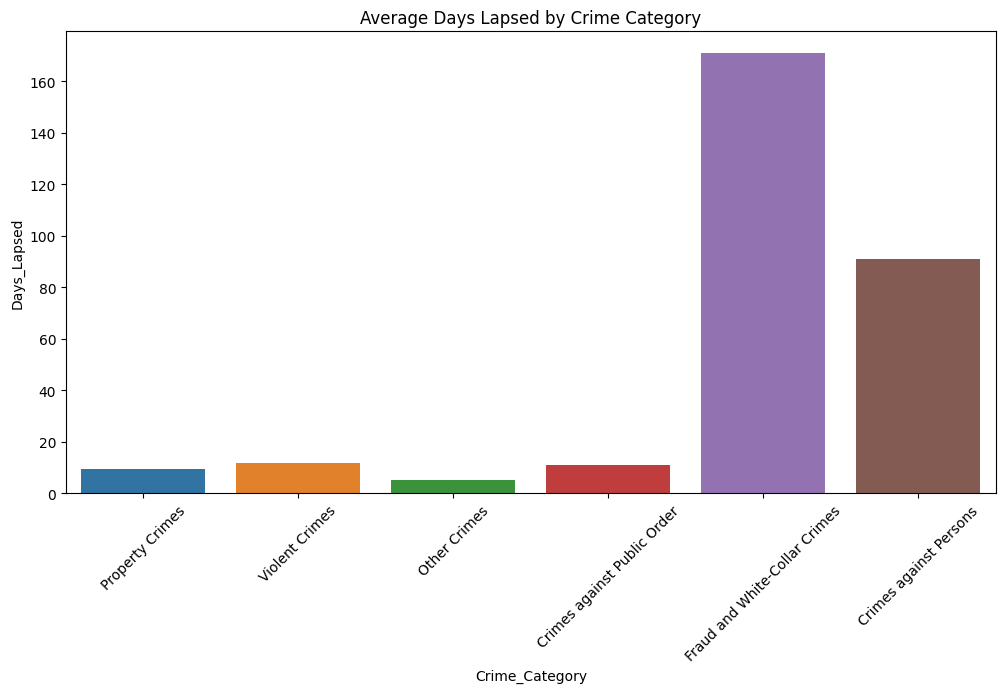

In [28]:
# Create a bar plot without confidence intervals
plt.figure(figsize=(12, 6))
sns.barplot(x='Crime_Category', y='Days_Lapsed', data=train_df, errorbar=None)
plt.title('Average Days Lapsed by Crime Category')
plt.xticks(rotation=45)
plt.show()

## **Fraud and white collar crime and Crime against persons crime are reported after 3 months of occurrance 

In [29]:
## Extract new information from date occurred column to check if crime occurred more on weekends or weekdays

train_df['Day_of_Week'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.day_name()
test_df['Day_of_Week'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p').dt.day_name()

In [30]:
train_df['Day_of_Week'].value_counts()

Day_of_Week
Friday       3010
Saturday     2932
Wednesday    2909
Thursday     2881
Tuesday      2782
Sunday       2751
Monday       2735
Name: count, dtype: int64

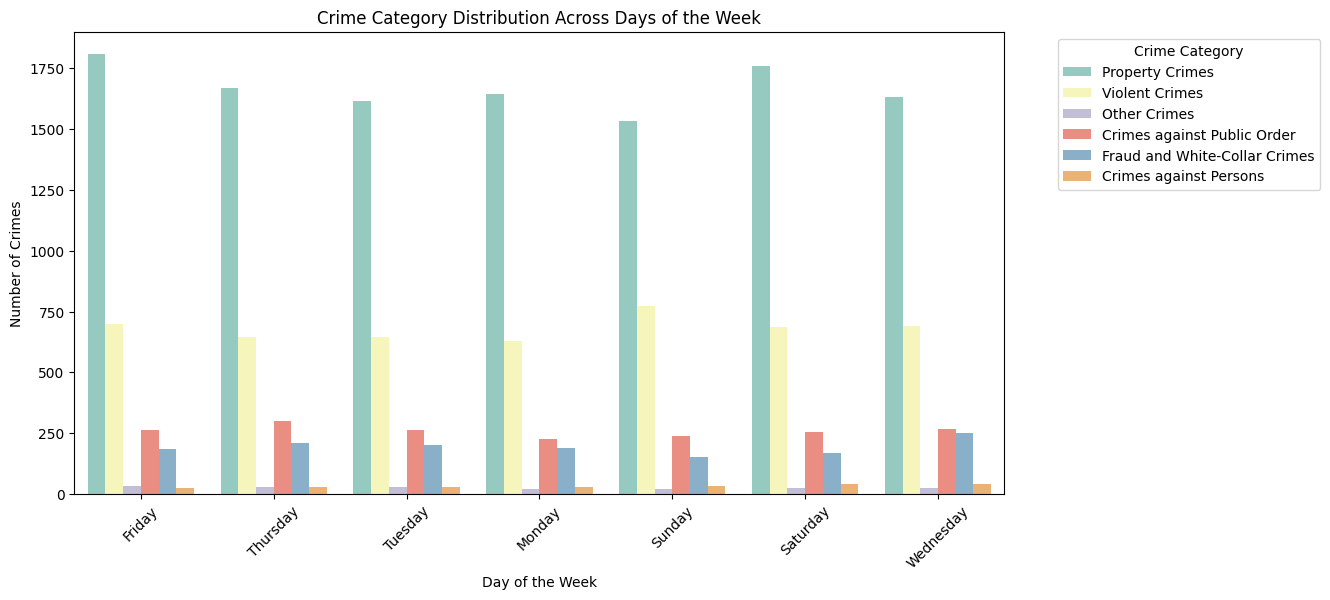

In [31]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Day_of_Week', hue='Crime_Category', palette='Set3')

# Set plot title and labels
plt.title('Crime Category Distribution Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **Crime occurred on almost all days of the week, we will drop this column later

In [32]:
## Examine the time_occurred column------it has a float datatype
train_df['Time_Occurred'].head()

0    1800.0
1    1345.0
2     605.0
3    1800.0
4    1130.0
Name: Time_Occurred, dtype: float64

In [33]:
## Convert time occurred column to time format
## The time is in 24 hr format, first we will convert it into string type then split and get the integer part, after that fill with extra 0 in front if it is less than 4 digit

train_df['Time_Occurred'] = train_df['Time_Occurred'].astype(str).str.split('.').str[0].str.zfill(4)
# Convert to time format
train_df['Time_Occurred'] = pd.to_datetime(train_df['Time_Occurred'], format='%H%M').dt.time

## Same thing for test set
test_df['Time_Occurred'] = test_df['Time_Occurred'].astype(str).str.split('.').str[0].str.zfill(4)
# Convert to time format
test_df['Time_Occurred'] = pd.to_datetime(test_df['Time_Occurred'], format='%H%M').dt.time

In [34]:
## Extract new features like hour and minute from time occurred column

train_df['Hour'] = train_df['Time_Occurred'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
train_df['Minute'] = train_df['Time_Occurred'].apply(lambda x: x.minute if pd.notnull(x) else np.nan)

test_df['Hour'] = test_df['Time_Occurred'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
test_df['Minute'] = test_df['Time_Occurred'].apply(lambda x: x.minute if pd.notnull(x) else np.nan)

In [35]:
## Extract new information like at what time of day the crime occurred to see if there are more crimes at specific time of the day
    
def get_part_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

train_df['Part_of_Day'] = train_df['Hour'].apply(get_part_of_day)
test_df['Part_of_Day'] = test_df['Hour'].apply(get_part_of_day)

In [36]:
train_df['Part_of_Day'].value_counts()

Part_of_Day
Afternoon    6683
Evening      6362
Morning      3994
Night        2961
Name: count, dtype: int64

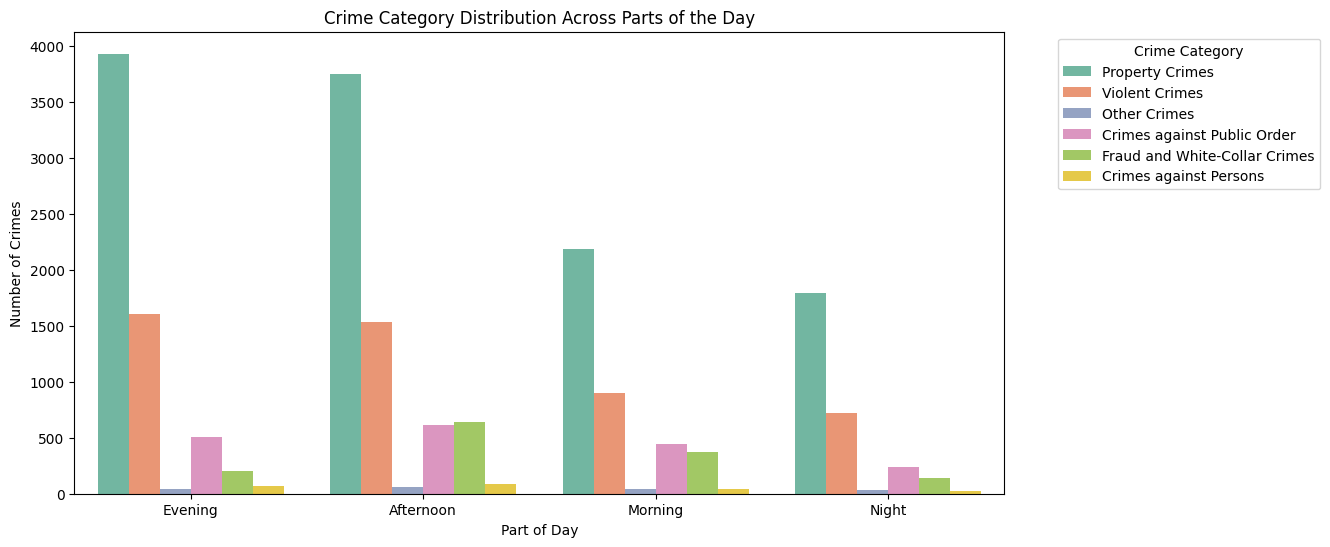

In [37]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Part_of_Day', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Parts of the Day')
plt.xlabel('Part of Day')
plt.ylabel('Number of Crimes')

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **Higher number of crimes occurred during evening and afternoon time 

In [38]:
## Examine area id column
## Check if area_id and area_name is different or same

area_pattern = train_df.groupby('Area_ID')['Area_Name'].unique().reset_index()
print(area_pattern)

## **Each area_id has only one value in area_name, so they are same
## **We will drop area name column so we dont have to encode it and increase features in dataset

    Area_ID      Area_Name
0       1.0      [Central]
1       2.0      [Rampart]
2       3.0    [Southwest]
3       4.0   [Hollenbeck]
4       5.0       [Harbor]
5       6.0    [Hollywood]
6       7.0     [Wilshire]
7       8.0      [West LA]
8       9.0     [Van Nuys]
9      10.0  [West Valley]
10     11.0    [Northeast]
11     12.0  [77th Street]
12     13.0       [Newton]
13     14.0      [Pacific]
14     15.0  [N Hollywood]
15     16.0     [Foothill]
16     17.0   [Devonshire]
17     18.0    [Southeast]
18     19.0      [Mission]
19     20.0      [Olympic]
20     21.0      [Topanga]


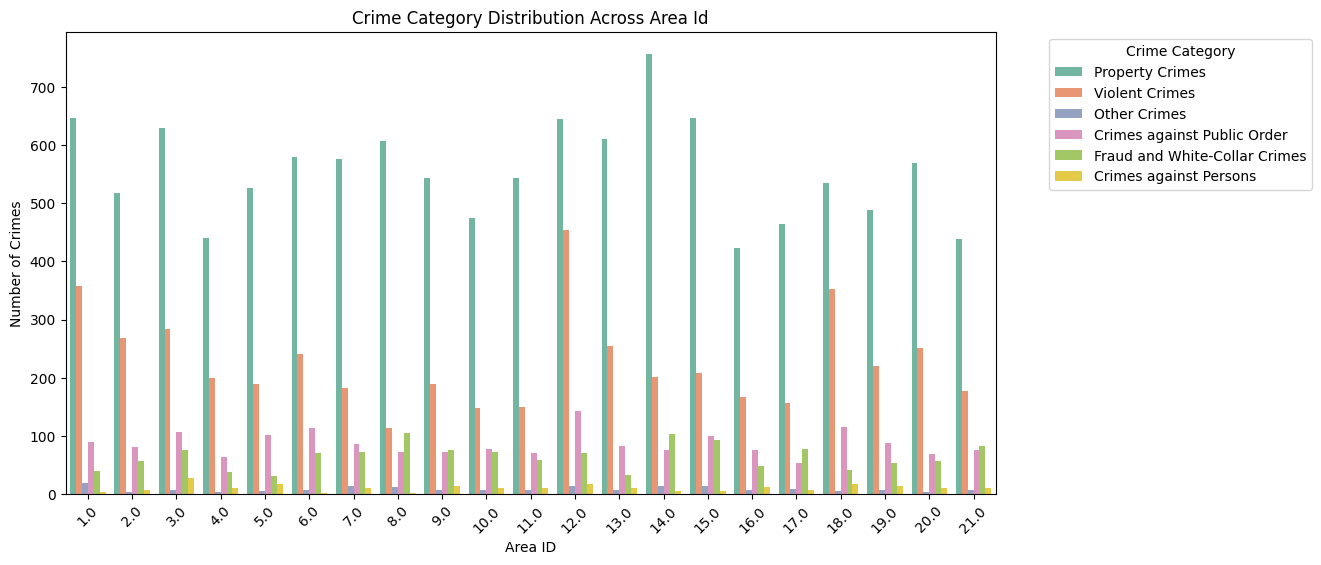

In [39]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Area_ID', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Area Id')
plt.xlabel('Area ID')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **There are higher number of cases from area id 14
## **There are higher number of Violent crimes occurred in area id 12

In [40]:
## Exammine reporting district no column

train_df['Reporting_District_no'].value_counts()

Reporting_District_no
645.0     99
162.0     85
1494.0    74
1822.0    72
182.0     72
          ..
452.0      1
871.0      1
1476.0     1
848.0      1
812.0      1
Name: count, Length: 1120, dtype: int64

In [41]:
train_df.isnull().sum()

Location                     0
Cross_Street                 0
Latitude                    78
Longitude                   78
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
Reported_Day                 0
Reported_Month               0
Reported_Year                0
Occurred_Day                 0
Occurred_Month               0
Occurred_Year                0
Days_Lapsed                  0
Day_of_Week                  0
Hour                         0
Minute                       0
Part_of_

In [42]:
## Examine part 1-2 column
train_df['Part 1-2'].value_counts()

Part 1-2
1.0    11637
2.0     8363
Name: count, dtype: int64

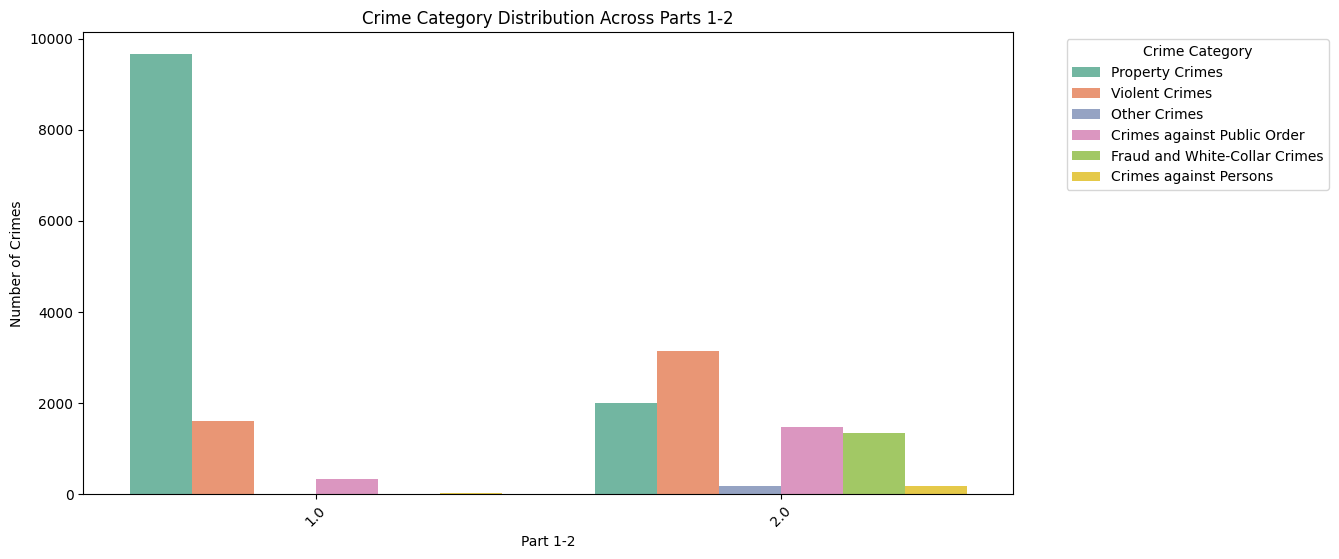

In [43]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Part 1-2', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Parts 1-2')
plt.xlabel('Part 1-2')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **There are higher number of Part 1 crimes
## **There are almost no Fraud and white collar crime and crime against persons in part 1 crime
## **There are higher number of Violent crimes in part 2 crime
## **There are higher number of Property crimes in part 1 crime

In [44]:
## Examine the Modus operandi column

train_df['Modus_Operandi'].head()

0                                       0385
1    0906 0352 0371 0446 1822 0344 0416 0417
2                                  0329 1202
3                                  0329 1300
4              0416 0945 1822 0400 0417 0344
Name: Modus_Operandi, dtype: object

In [45]:
## Extract codes from modus operandi column 

# Function to split the modus operandi column
def split_mo(mo):
    return mo.split() if mo else []

# Apply the function to get all codes in a list of lists
all_codes_train = train_df['Modus_Operandi'].astype(str).apply(split_mo)
all_codes_test = test_df['Modus_Operandi'].astype(str).apply(split_mo)

# Get the unique codes from both train and test sets
unique_codes = set(code for codes in all_codes_train for code in codes).union(set(code for codes in all_codes_test for code in codes))

# Create a dictionary to hold the new columns for train and test DataFrames
train_columns = {code: [] for code in unique_codes}
test_columns = {code: [] for code in unique_codes}

# Fill the new columns with 1 and 0
for codes in all_codes_train:
    for code in unique_codes:
        train_columns[code].append(1 if code in codes else 0)

for codes in all_codes_test:
    for code in unique_codes:
        test_columns[code].append(1 if code in codes else 0)

# Convert the dictionaries to dataframe
train_new_cols = pd.DataFrame(train_columns)
test_new_cols = pd.DataFrame(test_columns)

# Concatenate the new columns with the original dataframes
train_df = pd.concat([train_df, train_new_cols], axis=1)
test_df = pd.concat([test_df, test_new_cols], axis=1)  

In [46]:
## Examine the victime age column

train_df['Victim_Age'].describe()

count    20000.000000
mean        30.135000
std         21.863645
min         -2.000000
25%         12.000000
50%         31.000000
75%         46.000000
max         99.000000
Name: Victim_Age, dtype: float64

In [47]:
train_df['Victim_Age'].value_counts()

Victim_Age
 0.0     4828
 30.0     448
 31.0     446
 26.0     442
 29.0     425
         ... 
 98.0       2
-2.0        2
 92.0       2
 96.0       2
 94.0       2
Name: count, Length: 100, dtype: int64

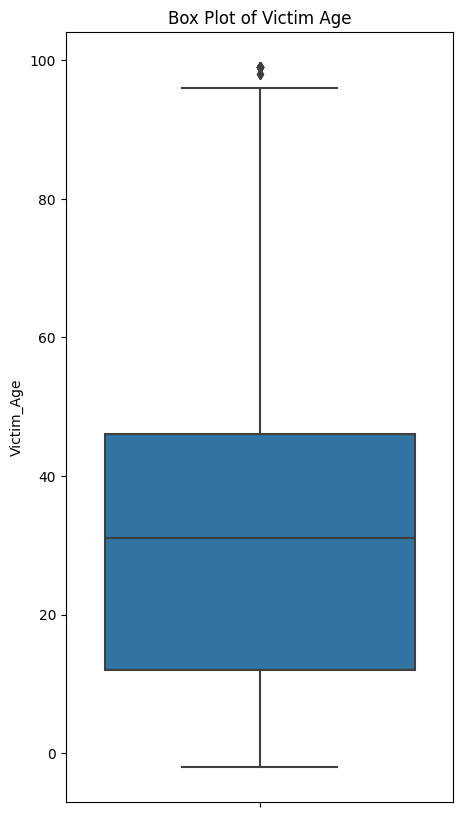

In [48]:
plt.figure(figsize=(5, 10))
sns.boxplot(data=train_df, y='Victim_Age')
plt.title('Box Plot of Victim Age')
plt.show()

In [49]:
## Calculating the lower and upper limit of victim age column using z-score
upper = train_df['Victim_Age'].mean() + 3*train_df['Victim_Age'].std()
lower = train_df['Victim_Age'].mean() - 3*train_df['Victim_Age'].std()
print(upper,lower)

95.72593522384916 -35.45593522384915


In [50]:
## capping the outliers 
train_df['Victim_Age'] = np.where(
    train_df['Victim_Age']>upper,
    upper,
    np.where(
        train_df['Victim_Age']<lower,
        lower, 
        train_df['Victim_Age']
    )
)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


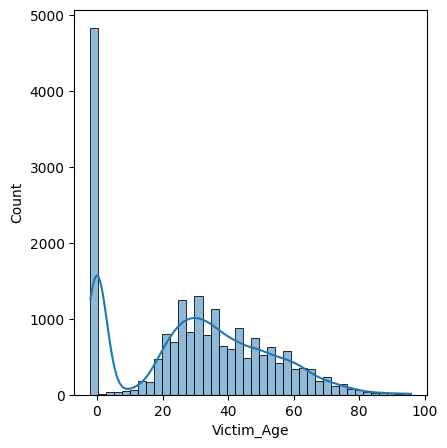

In [51]:
## Visualising the victim age column
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Victim_Age'], kde=True)
plt.show()
## **Large number of rows in victim age column has value 0

In [52]:
## Convert values less than equal 0 to nan because age cannot be 0 or negative and then impute with mean age

train_df['Victim_Age'] = train_df['Victim_Age'].apply(lambda x: np.nan if x <= 0 else x)
test_df['Victim_Age'] = test_df['Victim_Age'].apply(lambda x: np.nan if x <= 0 else x)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


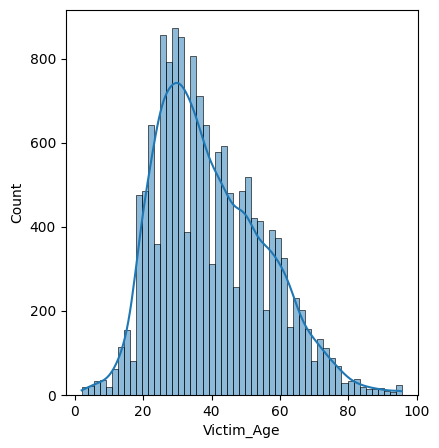

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Victim_Age'], kde=True)
plt.show()

## **It has the right skewed distribution means that there are higher number of young victims

In [54]:
## Examine victim sex column

train_df['Victim_Sex'].value_counts() 

Victim_Sex
M    8538
F    7176
X    1660
H       2
Name: count, dtype: int64

In [55]:
## 'H' is a outlier
# Replace 'H' with nan in the victim sex column and then impute with most frequent Victim sex
train_df['Victim_Sex'] = train_df['Victim_Sex'].replace(['H'], np.nan)
test_df['Victim_Sex'] = test_df['Victim_Sex'].replace(['H'], np.nan)

In [56]:
train_df['Victim_Sex'].value_counts() 

Victim_Sex
M    8538
F    7176
X    1660
Name: count, dtype: int64

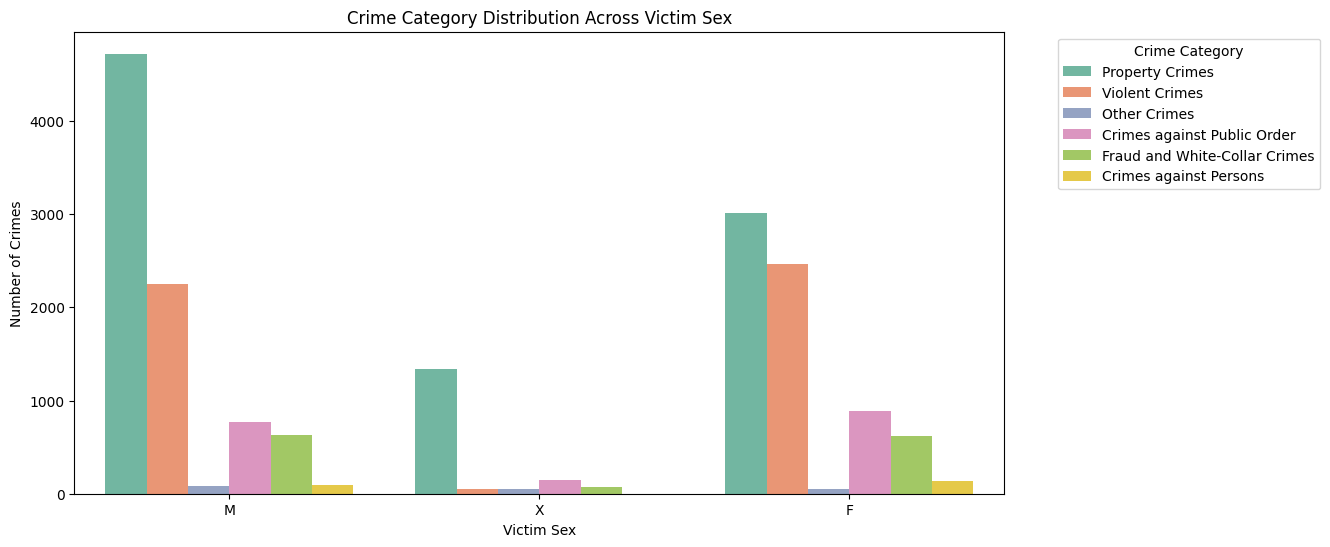

In [57]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Victim_Sex', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Victim Sex')
plt.xlabel('Victim Sex')
plt.ylabel('Number of Crimes')

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **Higher number of victim are Male

In [58]:
## Examine Victim Descent column

train_df['Victim_Descent'].value_counts()

Victim_Descent
H    6143
W    4245
B    2881
X    1849
O    1603
A     427
K      83
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: count, dtype: int64

In [59]:
## Also Victim descent column has null values which we will replace with most frequent during imputation
train_df['Victim_Descent'].isnull().sum()

2624

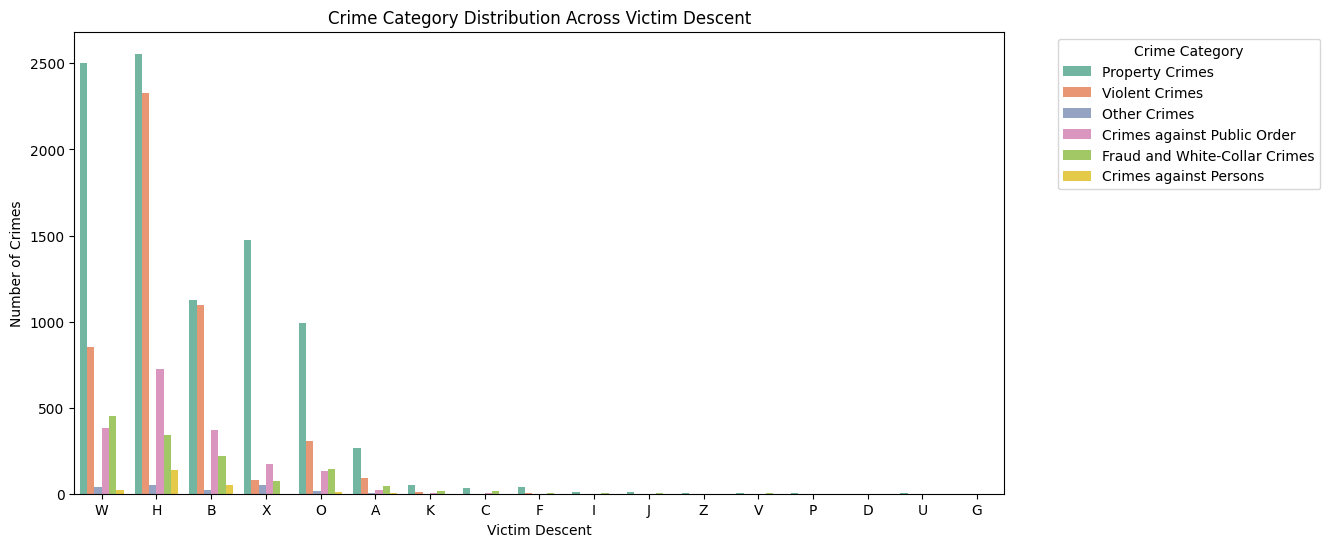

In [60]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Victim_Descent', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel('Number of Crimes')

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## There is a high Violent crimes for descent 'H' and almost equal property and violent crimes for descent 'B'

In [61]:
## Examine premise code and premise description column
## Check if premise_code and premise_description is different or same

premise_pattern = train_df.groupby('Premise_Code')['Premise_Description'].unique().reset_index()

## There will be one premise description for premise code if they represent same data
for i in premise_pattern['Premise_Description']:
    if len(i)>1:
        print(i)
        
## **premise_code and premise_description are same
## **We will drop premise description column so we dont have to encode it and increase features in dataset

In [62]:
train_df['Premise_Code'].value_counts()

Premise_Code
101.0    5033
501.0    3379
502.0    2491
108.0    1437
102.0     978
         ... 
214.0       1
909.0       1
896.0       1
744.0       1
250.0       1
Name: count, Length: 217, dtype: int64

In [63]:
## Examine weapon used code and weapon description column
## Check if weapon_used_code and weapon_description is different or same

weapon_pattern = train_df.groupby('Weapon_Used_Code')['Weapon_Description'].unique().reset_index()

## There will be one weapon description for weapon used code if they represent same data
for i in weapon_pattern['Weapon_Description']:
    if len(i)>1:
        print(i)
        
## **weapon_used_code and weapon_description are same
## **We will drop weapon description column so we dont have to encode it and increase features in dataset

In [64]:
train_df['Weapon_Used_Code'].value_counts().head()

Weapon_Used_Code
400.0    3990
500.0     789
511.0     546
102.0     388
200.0     160
Name: count, dtype: int64

In [65]:
## Examine status and status description column
## Check if status and status_description is different or same

status_pattern = train_df.groupby('Status')['Status_Description'].unique().reset_index()
print(status_pattern)

## **status and status_description are same
## **We will drop status description column so we dont have to encode it and increase features in dataset

  Status Status_Description
0     AA     [Adult Arrest]
1     AO      [Adult Other]
2     IC      [Invest Cont]
3     JA       [Juv Arrest]
4     JO        [Juv Other]


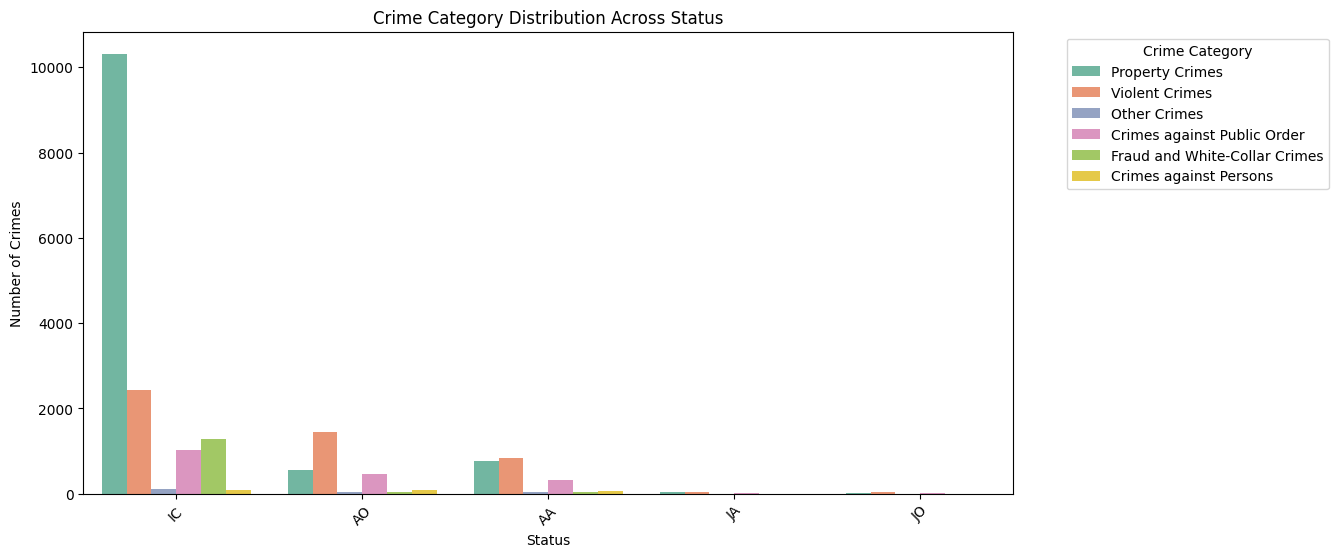

In [66]:
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=train_df, x='Status', hue='Crime_Category', palette='Set2')

# Set plot title and labels
plt.title('Crime Category Distribution Across Status')
plt.xlabel('Status')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **Higher number of property crimes has status IC

## Drop columns

In [67]:
## Drop unwanted columnns

train_df.drop(['Location','Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Area_Name','Modus_Operandi', 'Premise_Description','Weapon_Description', 'Status_Description','Hour','Minute','Reported_Day', 'Reported_Month','Reported_Year', 'Occurred_Day', 'Occurred_Month', 'Occurred_Year','Day_of_Week'], axis=1, inplace=True)
test_df.drop(['Location','Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Area_Name','Modus_Operandi', 'Premise_Description','Weapon_Description', 'Status_Description','Hour','Minute','Reported_Day', 'Reported_Month','Reported_Year', 'Occurred_Day', 'Occurred_Month', 'Occurred_Year','Day_of_Week'], axis=1, inplace=True)

## Split the dataset

In [68]:
##  Drop target column

X = train_df.drop(columns = 'Crime_Category')
y = train_df['Crime_Category'] 

In [69]:
## Split train set to train and validation set with 80:20 ratio

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42)

## Impute mising values

In [70]:
# Identify columns with null values
columns_with_nulls = train_df.columns[train_df.isnull().any()]

# Print the names of columns with null values
print(columns_with_nulls.tolist())

['Latitude', 'Longitude', 'Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Weapon_Used_Code']


In [71]:
## Fill null values

ct = ColumnTransformer(
    transformers=[
        ('impute_victim_age', SimpleImputer(strategy='mean'), ['Victim_Age']),
        ('impute_other', SimpleImputer(strategy='most_frequent'), ['Victim_Sex','Latitude','Longitude','Victim_Descent']),
        ('impute_weapon_used_code', SimpleImputer(strategy='constant', fill_value=0), ['Weapon_Used_Code'])
    ],
    remainder='passthrough',verbose_feature_names_out=False)

ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute_victim_age', SimpleImputer(),
                                 ['Victim_Age']),
                                ('impute_other',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Victim_Sex', 'Latitude', 'Longitude',
                                  'Victim_Descent']),
                                ('impute_weapon_used_code',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['Weapon_Used_Code'])],
                  verbose_feature_names_out=False)

In [72]:
# Fit and transform the training set
ct.fit_transform(X_train)

# Transform the validation and test sets
ct.transform(X_valid)
ct.transform(test_df)

# Convert the transformed arrays back to dataframes for easier handling
X_train = pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out())
X_valid = pd.DataFrame(ct.transform(X_valid), columns=ct.get_feature_names_out())
test_df = pd.DataFrame(ct.transform(test_df), columns=ct.get_feature_names_out())

## Encode categorical columns

In [73]:
oh_cols = ['Victim_Sex','Status','Part_of_Day','Victim_Descent']

In [74]:
## Apply one hot encoder to categorical columns

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_oh = pd.DataFrame(ohe_encoder.fit_transform(X_train[oh_cols]), index=X_train.index, columns=ohe_encoder.get_feature_names_out())

X_valid_oh = pd.DataFrame(ohe_encoder.transform(X_valid[oh_cols]), index=X_valid.index, columns=ohe_encoder.get_feature_names_out())

test_df_oh = pd.DataFrame(ohe_encoder.transform(test_df[oh_cols]), index=test_df.index,columns=ohe_encoder.get_feature_names_out())

In [75]:
## Join the encoded columns to original dataframe 
X_train = X_train.join(X_train_oh).drop(oh_cols,axis=1)
X_valid = X_valid.join(X_valid_oh).drop(oh_cols,axis=1)
test_df = test_df.join(test_df_oh).drop(oh_cols,axis=1)

In [76]:
## Datatype of columns converted to object beacuse of imputation and encoding, so we'll convert it to float datatype before scaling
num_column = X_train.select_dtypes(include=['object']).columns
num_column

Index(['Victim_Age', 'Latitude', 'Longitude', 'Weapon_Used_Code',
       'Cross_Street', 'Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Premise_Code', 'Days_Lapsed',
       ...
       '0210', '1402', '1260', '0105', '0400', '2043', '0505', '1234', '0410',
       '2204'],
      dtype='object', length=510)

In [77]:
for col in num_column:
    X_train[col] = X_train[col].astype(float)
    X_valid[col] = X_valid[col].astype(float)
    test_df[col] = test_df[col].astype(float)

## Scale numerical columns

In [78]:
## Copy the train , valid and test set so that we can perform Standard scaler as well and check if it was making any difference

X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_copy = test_df.copy()

In [79]:
## Apply min max scaler to train, valid and test set
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()   
X_train = pd.DataFrame(scaler.fit_transform(X_train) , index = X_train.index,columns = X_train.columns)   
X_valid = pd.DataFrame(scaler.transform(X_valid) , index = X_valid.index,columns = X_valid.columns) 
test_df = pd.DataFrame(scaler.transform(test_df) , index = test_df.index,columns = test_df.columns) 

In [80]:
X_train.head()

,Victim_Age,Latitude,Longitude,Weapon_Used_Code,Cross_Street,Area_ID,Reporting_District_no,Part 1-2,Premise_Code,Days_Lapsed,...,Victim_Descent_I,Victim_Descent_J,Victim_Descent_K,Victim_Descent_O,Victim_Descent_P,Victim_Descent_U,Victim_Descent_V,Victim_Descent_W,Victim_Descent_X,Victim_Descent_Z
0,0.245396,0.513122,0.891688,0.198058,1.0,0.15,0.184160,0.0,0.000000,0.000712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.288074,0.566414,0.875422,0.776699,0.0,0.15,0.162214,1.0,0.003468,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.234727,0.447593,0.380877,0.000000,0.0,0.65,0.634542,0.0,0.463584,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.512131,0.606183,0.672287,0.970874,0.0,0.25,0.274332,0.0,0.700578,0.022776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.309413,0.819031,0.581432,0.000000,0.0,0.75,0.756679,0.0,0.117919,0.001423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


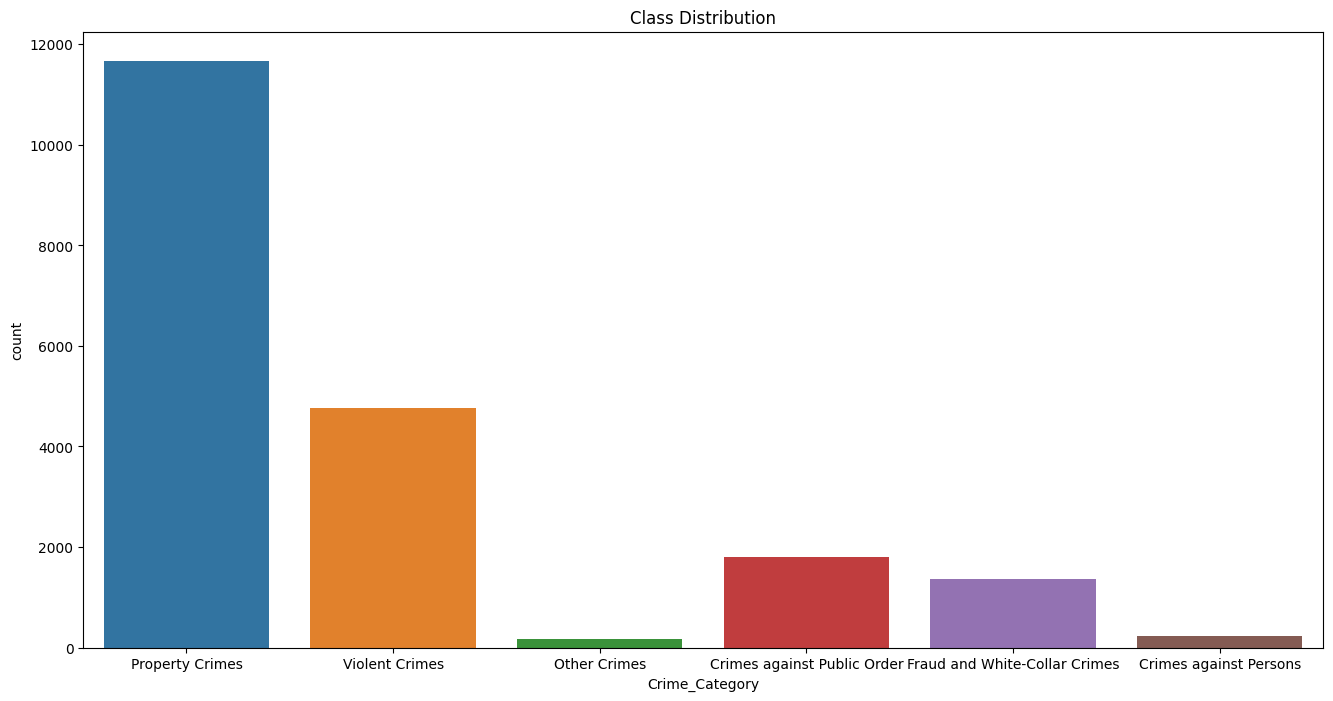

In [81]:
## Examine the target column

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
sns.countplot(x='Crime_Category', data=train_df)
plt.title('Class Distribution')
plt.show()

## **There is a class imbalance in the target column

In [82]:
print(X_train.shape)  
print(X_valid.shape)  
print(test_df.shape) 

(16000, 539)
(4000, 539)
(5000, 539)


## Feature engeneering

In [116]:
## Lets visualise the target column

from sklearn.decomposition import PCA
import plotly.express as px

# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
X_train_trf = pca.fit_transform(X_train)
y_train_trf = y_train

# Create a DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame({
    'PCA1': X_train_trf[:, 0],  # First principal component
    'PCA2': X_train_trf[:, 1],  # Second principal component
    'Crime_Category': y_train_trf
})

# Create the scatter plot using Plotly
fig = px.scatter(df,
                 x='PCA1',
                 y='PCA2',
                 color='Crime_Category',
                 title='2D PCA Visualization of Crime Categories',
                 color_discrete_sequence=px.colors.qualitative.G10)

# Show the plot
fig.show()

In [84]:
## Tuning PCA Components for Optimal Logistic Regression Accuracy

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score 

# best_accuracy = 0
# best_i = 0

# for i in range(1, 540):
#     pca = PCA(n_components=i)
#     X_train_trf = pca.fit_transform(X_train)
#     X_valid_trf = pca.transform(X_valid)

#     lr = LogisticRegression(max_iter=2000, random_state=42)
#     lr.fit(X_train_trf, y_train)
#     y_pred = lr.predict(X_valid_trf)

#     accuracy = accuracy_score(y_valid, y_pred)

#     # Print the accuracy score for the current value of i
#     print(f'Accuracy for {i} components: {accuracy}')

#     # Update the best accuracy and best i if the current accuracy is better
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_i = i

# # Print the best accuracy and corresponding i value
# print(f'Best accuracy: {best_accuracy} with {best_i} components')
# Best accuracy: 0.9465 with 240 components  

# **PCA works well for Logistic Regression because it helps in reducing dimensionality, capturing the most important variance in the data. 
# **However, PCA may not perform as well with Decision Tree models since Decision Trees do not rely on linear assumptions and can naturally handle high-dimensional data.
# **Reducing dimensions via PCA could remove important features that Decision Trees might otherwise use to make accurate splits.

# Model training and evaluation

## Logistic Regression

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Create the pipeline with StandardScaler and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit the training data
pipeline.fit(X_train_copy, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_valid_copy)

# Evaluate the model
print("\nLogistic Regression with StandardScaler:")
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred)) 


Logistic Regression with StandardScaler:
Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.45      0.44      0.44        32
  Crimes against Public Order       0.80      0.82      0.81       374
Fraud and White-Collar Crimes       0.94      0.93      0.93       267
                 Other Crimes       0.41      0.34      0.38        35
              Property Crimes       0.98      0.98      0.98      2303
               Violent Crimes       0.92      0.92      0.92       989

                     accuracy                           0.94      4000
                    macro avg       0.75      0.74      0.74      4000
                 weighted avg       0.94      0.94      0.94      4000

Accuracy Score: 0.9385
Confusion Matrix:
[[  14    2    2    0    0   14]
 [   1  305   10   10   14   34]
 [   0   15  247    3    2    0]
 [   0   15    2   12    5    1]
 [   0   10    2    1 2265   25]
 [  16   34    

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Train model using MinMaxScaler
model1 = LogisticRegression(max_iter=2000, random_state=42)

# Fit the training data
model1.fit(X_train, y_train)

# Make predictions on the validation set 
y_pred = model1.predict(X_valid)

# Evaluate the model
print("\nL2 Regularization with MinMaxScaler:")
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))


L2 Regularization with MinMaxScaler:
Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.58      0.47      0.52        32
  Crimes against Public Order       0.81      0.82      0.82       374
Fraud and White-Collar Crimes       0.92      0.95      0.94       267
                 Other Crimes       0.62      0.23      0.33        35
              Property Crimes       0.98      0.98      0.98      2303
               Violent Crimes       0.93      0.94      0.93       989

                     accuracy                           0.94      4000
                    macro avg       0.81      0.73      0.75      4000
                 weighted avg       0.94      0.94      0.94      4000

Accuracy Score: 0.9445
Confusion Matrix:
[[  15    1    1    0    0   15]
 [   2  307   13    3   14   35]
 [   0   12  253    1    1    0]
 [   0   17    5    8    5    0]
 [   2   11    2    1 2264   23]
 [   7   30    0   

In [87]:
## Acuuracy score by using standard scaler = 0.9385
## Acuuracy score by using MinMaX scaler = 0.9445
## training model on MinMaxScaler performed well than Standard Scaler

In [88]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model1, X_train, y_train, cv=5, scoring='accuracy') 

# Print the cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Cross-validation scores:  [0.9428125 0.941875  0.9425    0.9453125 0.9453125]
Mean accuracy:  0.9435625
Standard deviation:  0.00146041518069348


## Decision tree

In [89]:
from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(random_state=42)

# # Define the parameter grid
# param_grid = {
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 10, 20, 30],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'max_features': [None, 'sqrt', 'log2'],
#     'criterion': ['gini', 'entropy'] 
# } 

# # Define Grid Search with cross-validation
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print("Best hyperparameters: ", grid_search.best_params_)

# # Evaluate the model
# best_model = grid_search.best_estimator_
# accuracy = best_model.score(X_valid, y_valid)
# y_pred = best_model.predict(X_valid)
# print("Validation accuracy: ", accuracy(y_valid, y_pred))
# print('Confusion Matrix:')
# print(confusion_matrix(y_valid, y_pred))


# **Best hyperparameters:  {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 30}
# **Validation accuracy:  0.94025

In [90]:
from sklearn.tree import DecisionTreeClassifier
## evaluate on best hyperparameters
model2 = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=20, 
    max_features=None, 
    min_samples_leaf=2, 
    min_samples_split=30, 
    random_state=42)

## fit train set
model2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=30,
                       random_state=42)

In [91]:
## predict on validation set
y_pred = model2.predict(X_valid) 

## evaluate the model
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))  
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))

Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.54      0.88      0.67        32
  Crimes against Public Order       0.78      0.81      0.80       374
Fraud and White-Collar Crimes       0.95      0.91      0.93       267
                 Other Crimes       0.39      0.20      0.26        35
              Property Crimes       0.99      0.98      0.99      2303
               Violent Crimes       0.93      0.92      0.92       989

                     accuracy                           0.94      4000
                    macro avg       0.76      0.78      0.76      4000
                 weighted avg       0.94      0.94      0.94      4000

Accuracy Score: 0.94075
Confusion Matrix:
[[  28    0    0    0    0    4]
 [   4  304    5    9   10   42]
 [   0   22  242    1    1    1]
 [   1   17    7    7    2    1]
 [   2    5    1    1 2268   26]
 [  17   41    0    0   17  914]]


In [92]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='accuracy') 

# Print the cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Cross-validation scores:  [0.945625  0.931875  0.9403125 0.9434375 0.944375 ]
Mean accuracy:  0.9411249999999999
Standard deviation:  0.00494737935679083


In [93]:
## **Decion tree performed fast with large dataset

## Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model3 = RandomForestClassifier(random_state=42, n_estimators=100)    ## by default for random forest, base model is decision tree

In [95]:
## fit on train set
model3.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
## predict on validation set
y_pred = model3.predict(X_valid) 

## evaluate performance
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))  
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))

Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.73      0.25      0.37        32
  Crimes against Public Order       0.87      0.80      0.84       374
Fraud and White-Collar Crimes       0.95      0.93      0.94       267
                 Other Crimes       0.50      0.06      0.10        35
              Property Crimes       0.98      0.98      0.98      2303
               Violent Crimes       0.90      0.98      0.94       989

                     accuracy                           0.95      4000
                    macro avg       0.82      0.67      0.69      4000
                 weighted avg       0.94      0.95      0.94      4000

Accuracy Score: 0.94675
Confusion Matrix:
[[   8    3    0    0    1   20]
 [   1  300    7    2   13   51]
 [   0   14  248    0    5    0]
 [   0   18    4    2   11    0]
 [   0    1    3    0 2260   39]
 [   2    8    0    0   10  969]]


In [97]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring='accuracy') 

# Print the cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Cross-validation scores:  [0.9496875 0.9471875 0.9465625 0.944375  0.9440625]
Mean accuracy:  0.9463750000000001
Standard deviation:  0.0020501524333570937


## Multi layer Perceptron

In [98]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLPClassifier
model4 = MLPClassifier(hidden_layer_sizes=(100, 50),max_iter=300,random_state=42)              

# Fit the model to the training data
model4.fit(X_train, y_train)

# Make predictions on the valid set
y_pred = model4.predict(X_valid)

# Evaluate the model
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred)) 

Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.47      0.47      0.47        32
  Crimes against Public Order       0.78      0.83      0.80       374
Fraud and White-Collar Crimes       0.97      0.89      0.93       267
                 Other Crimes       0.41      0.46      0.43        35
              Property Crimes       0.98      0.98      0.98      2303
               Violent Crimes       0.93      0.92      0.92       989

                     accuracy                           0.94      4000
                    macro avg       0.76      0.76      0.76      4000
                 weighted avg       0.94      0.94      0.94      4000

Accuracy Score: 0.937
Confusion Matrix:
 [[  15    4    2    0    0   11]
 [   2  311    1   12   19   29]
 [   1   20  238    7    1    0]
 [   0   14    1   16    3    1]
 [   1    9    4    3 2258   28]
 [  13   41    0    1   24  910]]


## KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier

# # Define the KNN model
# knn_model = KNeighborsClassifier()

# # Define the hyperparameter grid for n_neighbors
# param_distributions = {
#     'n_neighbors': np.arange(1, 21)  # Testing values from 1 to 20
# }

# # Set up the RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=knn_model,
#                                    param_distributions=param_distributions,
#                                    scoring='accuracy',
#                                    cv=3,
#                                    n_jobs=-1,  
#                                    verbose=1,  
#                                    random_state=42) 

# # Fit the RandomizedSearchCV
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best parameters found: ", random_search.best_params_)
# print("Best accuracy score found: ", random_search.best_score_)

# # Evaluate the best model on the validation set
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_valid)

# print("\nClassification Report:\n", classification_report(y_valid, y_pred))
# print("Accuracy Score:", accuracy_score(y_valid, y_pred))

# Fitting 3 folds for each of 10 candidates, totalling 30 fits
# Best parameters found:  {'n_neighbors': 4}

In [100]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize variables to store the best score and corresponding n_neighbors
best_score = 0
best_n = 0

for n in range(1, 20):  
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    
    # If the current score is better than the best score, update the best score and n_neighbors
    if score > best_score:
        best_score = score
        best_n = n

#     print(f'n_neighbors = {n}, Accuracy = {score:.4f}')

print(f'Best n_neighbors: {best_n} with accuracy of {best_score:.4f}')


Best n_neighbors: 4 with accuracy of 0.8948


In [101]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

model5 = KNeighborsClassifier(
    n_neighbors=4
)

## fit on train set
model5.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [102]:
## predict on validation set

y_pred = model5.predict(X_valid) 

## evaluate the model
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))  
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))

Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.28      0.16      0.20        32
  Crimes against Public Order       0.68      0.74      0.71       374
Fraud and White-Collar Crimes       0.84      0.82      0.83       267
                 Other Crimes       0.33      0.03      0.05        35
              Property Crimes       0.94      0.97      0.96      2303
               Violent Crimes       0.90      0.85      0.87       989

                     accuracy                           0.89      4000
                    macro avg       0.66      0.59      0.60      4000
                 weighted avg       0.89      0.89      0.89      4000

Accuracy Score: 0.89475
Confusion Matrix:
[[   5    7    0    0    2   18]
 [   2  276   24    0   38   34]
 [   0   27  220    1   19    0]
 [   0   16    5    1   10    3]
 [   0   17    7    0 2237   42]
 [  11   60    5    1   72  840]]


In [103]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
scores = cross_val_score(model5, X_train, y_train, cv=3, scoring='accuracy') 

# Print the cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Cross-validation scores:  [0.88170229 0.88749297 0.88730546]
Mean accuracy:  0.8855002373718849
Standard deviation:  0.002686647131278355


## SVM

In [104]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

model6 = SVC(kernel='rbf', random_state=42)  

# Fit the model on the training data
model6.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model6.predict(X_valid)

# Evaluate the model
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy Score:", accuracy_score(y_valid, y_pred))  
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))
# Accuracy Score: 0.944

Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.63      0.38      0.47        32
  Crimes against Public Order       0.79      0.83      0.81       374
Fraud and White-Collar Crimes       0.92      0.93      0.93       267
                 Other Crimes       0.50      0.03      0.05        35
              Property Crimes       0.99      0.98      0.99      2303
               Violent Crimes       0.92      0.95      0.93       989

                     accuracy                           0.94      4000
                    macro avg       0.79      0.68      0.70      4000
                 weighted avg       0.94      0.94      0.94      4000

Accuracy Score: 0.944
Confusion Matrix:
[[  12    2    1    0    0   17]
 [   3  310   11    1   13   36]
 [   0   16  249    0    0    2]
 [   0   25    6    1    2    1]
 [   0    8    2    0 2262   31]
 [   4   31    2    0   10  942]]


In [105]:
scores = cross_val_score(model6, X_train, y_train, cv=3, scoring='accuracy') 

# Print the cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Cross-validation scores:  [0.94469441 0.94580911 0.94843428]
Mean accuracy:  0.9463126011367461
Standard deviation:  0.0015677522668240498


## Bagging

In [106]:
## Finding best parameter for bagging classifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

# base_estimator = DecisionTreeClassifier(random_state=42)
# bagging_clf = BaggingClassifier(base_estimator=base_estimator, random_state=42)

# # Define the hyperparameters for GridSearch
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_samples': [0.5, 1.0],
#     'max_features': [0.5, 1.0],
#     'bootstrap': [True, False],
#     'bootstrap_features': [True, False]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the best score
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best cross-validation accuracy: {grid_search.best_score_}") 

In [107]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the base estimator
estimator = DecisionTreeClassifier(random_state=42)

# Initialize the BaggingClassifier with parameters
bagging_clf = BaggingClassifier(
    estimator=estimator,
    bootstrap=True,
    bootstrap_features=False,
    max_features=1.0,
    max_samples=0.5,
    n_estimators=100,
    random_state=42
)

# Fit the BaggingClassifier to the training data
bagging_clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = bagging_clf.predict(X_valid)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_valid, y_pred)

print(f"Test accuracy: {test_accuracy}")

print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

Test accuracy: 0.95075
Confusion Matrix:
[[  23    0    0    0    0    9]
 [   4  314    6    5    9   36]
 [   0   22  243    1    0    1]
 [   1   15    8    8    2    1]
 [   0    4    1    0 2270   28]
 [   6   24    0    0   14  945]]
Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.68      0.72      0.70        32
  Crimes against Public Order       0.83      0.84      0.83       374
Fraud and White-Collar Crimes       0.94      0.91      0.93       267
                 Other Crimes       0.57      0.23      0.33        35
              Property Crimes       0.99      0.99      0.99      2303
               Violent Crimes       0.93      0.96      0.94       989

                     accuracy                           0.95      4000
                    macro avg       0.82      0.77      0.79      4000
                 weighted avg       0.95      0.95      0.95      4000



In [108]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
scores = cross_val_score(bagging_clf, X_train, y_train, cv=5, scoring='accuracy') 

# Print the cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

Cross-validation scores:  [0.950625  0.95125   0.954375  0.9546875 0.9509375]
Mean accuracy:  0.952375
Standard deviation:  0.0017743836958222844


In [109]:
## Final submission with test data
y_pred = bagging_clf.predict(test_df)

# Conclusion

In [110]:
model_names = ['Logistic Regression', 'Decision tree', 'Random Forest', 'MLP classifier', 'KNN', 'SVC', 'Bagging Classifier']
models = [model1, model2, model3, model4, model5, model6, bagging_clf]

results = []
for i, model in enumerate(models):
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    report = classification_report(y_valid, y_pred, output_dict=True)
    results.append({
        'Model': model_names[i],
        'Accuracy': acc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision   Recall  F1-Score
0  Logistic Regression   0.94450   0.942354  0.94450  0.942581
1        Decision tree   0.94075   0.941092  0.94075  0.940273
2        Random Forest   0.94675   0.942698  0.94675  0.941669
3       MLP classifier   0.93700   0.938631  0.93700  0.937616
4                  KNN   0.89475   0.888704  0.89475  0.890070
5                  SVC   0.94400   0.940502  0.94400  0.940007
6   Bagging Classifier   0.95075   0.949293  0.95075  0.949295


In [111]:
#                                   Precision   Recall    F1-score  Support
## logistic regression
#                      accuracy                           0.94      4000
#                     macro avg       0.81      0.73      0.75      4000
#                  weighted avg       0.94      0.94      0.94      4000

## Decision tree
#                      accuracy                           0.94      4000
#                     macro avg       0.76      0.78      0.76      4000
#                  weighted avg       0.94      0.94      0.94      4000

## Multi layer perceptron
#                     accuracy                           0.94      4000
#                     macro avg       0.71      0.69      0.70      4000
#                  weighted avg       0.94      0.94      0.93      4000

## KNN
#                      accuracy                           0.89      4000
#                     macro avg       0.66      0.59      0.60      4000
#                  weighted avg       0.89      0.89      0.89      4000

## SVM
#                      accuracy                           0.94      4000
#                     macro avg       0.79      0.68      0.70      4000
#                  weighted avg       0.94      0.94      0.94      4000

## Random forest
#                      accuracy                           0.95      4000
#                     macro avg       0.86      0.69      0.72      4000
#                  weighted avg       0.95      0.95      0.95      4000


## Bagging
#                      accuracy                           0.95      4000
#                     macro avg       0.84      0.79      0.80      4000
#                  weighted avg       0.95      0.95      0.95      4000

## **KNN has the least accuracy score because it may not handle high-dimensional or noisy data as effectively as other algorithms.
## **Random Forest also performed really well
## **Bagging performed well because it reduces variance by combining predictions from multiple models, which improves overall accuracy.
## **Based on the results, Bagging has demonstrated the highest accuracy with high average precision,f1 score and recall, making it the best choice for the final submission.

# Submission

In [112]:
## Final submission with test data
y_pred = bagging_clf.predict(test_df)

In [113]:
submission = pd.DataFrame({"ID":np.arange(1,5001), "Crime_Category":y_pred})
submission.to_csv('submission.csv',index=False)   
submission.head()

,ID,Crime_Category
0,1,Violent Crimes
1,2,Property Crimes
2,3,Fraud and White-Collar Crimes
3,4,Property Crimes
4,5,Crimes against Public Order
